## Imports and Setup

In [1]:
import os
import sys
sys.path.insert(0, "../utils/")
import geoutils
import cnn_utils
import config

import pandas as pd
import numpy as np
import geopandas as gpd

import torch
import torchsummary

pd.set_option('mode.chained_assignment', None)
%load_ext autoreload
%autoreload 2

## Load Dataset

INFO:root:{'BLUE_TARP': 0, 'CONCRETE_CEMENT': 1, 'HEALTHY_METAL': 2, 'INCOMPLETE': 3, 'IRREGULAR_METAL': 4}


Config: {'rasters_dir': '../data/rasters/', 'csv_dir': '../data/csv/', 'exp_dir': '../exp/', 'version': 'version_02', 'attribute': 'roof_material', 'exp_name': 'exp_01', 'mode': 'RGB', 'batch_size': 32, 'n_workers': 4, 'n_epochs': 30, 'model': 'resnet50', 'resampler': None, 'pretrained': True, 'scheduler': 'ReduceLROnPlateau', 'optimizer': 'Adam', 'label_smoothing': 0.1, 'lr': 1e-05, 'img_size': 224, 'patience': 7, 'dropout': 0.5, 'momentum': None, 'gamma': None, 'step_size': None}


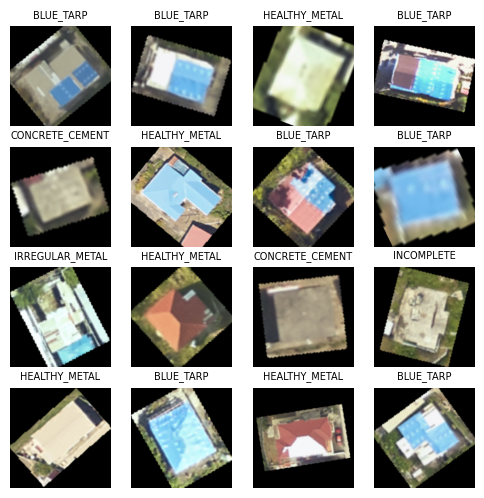

In [4]:
phases = ["train", "test"]
c = config.create_config("../configs/cnn/cnn_01.yaml", prefix='.')
print(f"Config: {c}")

data, data_loader, classes = cnn_utils.load_dataset(config=c, phases=phases)   
cnn_utils.visualize_data(data, data_loader, phase='train', mode=c['mode'])

Config: {'data_dir': '../data/rasters/Tiles/ortho/', 'csv_dir': '../data/csv/', 'attribute': 'roof_material', 'exp_name': 'exp-09', 'mode': 'RGB', 'batch_size': 32, 'n_workers': 4, 'n_epochs': 30, 'model': 'efficientnetb0', 'pretrained': True, 'scheduler': 'ReduceLROnPlateau', 'optimizer': 'Adam', 'lr': 1e-05, 'img_size': 224, 'momentum': None, 'gamma': None, 'step_size': None, 'patience': 7, 'dropout': None}
{'BLUE_TARP': 0, 'CONCRETE_CEMENT': 1, 'HEALTHY_METAL': 2, 'INCOMPLETE': 3, 'IRREGULAR_METAL': 4}


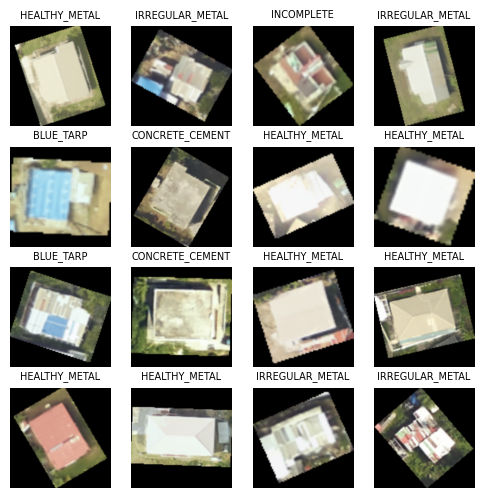

In [3]:
phases = ["train", "test"]
c = config.create_config("../configs/cnn/cnn_05.yaml")
c = {key: '.' + value if 'dir' in key else value for key, value in c.items()}
print(f"Config: {c}")

data, data_loader, classes = cnn_utils.load_dataset(config=c, phases=phases)   
cnn_utils.visualize_data(data, data_loader, phase='test', mode=c['mode'])

## Load Model

In [26]:
from torch_lr_finder import LRFinder
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, criterion, optimizer, scheduler = cnn_utils.load_model(
    n_classes=len(classes),
    model_type=c["model"],
    pretrained=c["pretrained"],
    scheduler_type=c["scheduler"],
    optimizer_type=c["optimizer"],
    lr=c["lr"],
    momentum=c["momentum"],
    gamma=c["gamma"],
    step_size=c["step_size"],
    patience=c["patience"],
    dropout=c["dropout"],
    device=device,
    mode=c['mode']
)
print(model)
torchsummary.summary(model, (3, c['img_size'], c['img_size']))

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
from sklearn.externals import joblib


pipeline = joblib.load('path.x')